## Traininig the Inclusive classifier with tf.keras using data in TFRecord format

**tf.keras Inclusive classifier, Transformer-based model** This notebooks trains a  neural network for the particle classifier using the Inclusive Classifier, using as input the full list of recunstructed particles and the High Level Features. Data is prepared in TFRecord format converting from Parquet using Apache Spark. Tensorflow data procesing uses tf.data and tf.io. 
This notebook uses a Transformerlayer instead of a GRU in the neural network for the Inclusive classifier

Credits: this notebook is part of the work: 
- [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
- Code and data at:https://github.com/cerndb/SparkDLTrigger  

The model is a classifier implemented as the concatenation of a Dense Neural Network and a Transformer
 - input: 14 high-level features and an array of 801 particles with 19 low-level features, described in [ Topology classification with deep learning to improve real-time event selection at the LHC](https://link.springer.com/epdf/10.1007/s41781-019-0028-1?author_access_token=eTrqfrCuFIP2vF4nDLnFfPe4RwlQNchNByi7wbcMAY7NPT1w8XxcX1ECT83E92HWx9dJzh9T9_y5Vfi9oc80ZXe7hp7PAj21GjdEF2hlNWXYAkFiNn--k5gFtNRj6avm0UukUt9M9hAH_j4UR7eR-g%3D%3D)
 - output: 3 classes, "W + jet", "QCD", "t tbar", see also [Machine Learning Pipelines with Modern Big Data Tools for High Energy Physics Comput Softw Big Sci 4, 8 (2020)](https://rdcu.be/b4Wk9)  
 - Open dataset: [download data](https://github.com/cerndb/SparkDLTrigger/tree/master/Data)
 

## Create the Keras model for the inclusive classifier

In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Sequential, Input, Model
from tensorflow.keras.layers import Masking, Dense, Activation, GRU, Dropout, concatenate

2023-06-03 20:52:24.760607: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-03 20:52:25.022986: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
tf.version.VERSION

'2.12.0'

In [3]:
# Check that we have a GPU available
tf.config.list_physical_devices('GPU')

2023-06-03 20:52:34.926031: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-06-03 20:52:34.966546: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 20:52:34.967317: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


In [4]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, TimeDistributed

# Define input layer
transformer_input = Input(shape=(801, 19), name='transformer_input')

# Apply multi-head self-attention
attention_layer = MultiHeadAttention(num_heads=8, key_dim=19)
attention_output = attention_layer(transformer_input, transformer_input, transformer_input)
attention_output = LayerNormalization(epsilon=1e-6)(attention_output)
attention_output = Dropout(0.2)(attention_output)

# Apply time-distributed dense layer
td_layer = TimeDistributed(Dense(20, activation='relu'))
td_output = td_layer(attention_output)

# Flatten the output of the previous layer
flatten_layer = Flatten()
flatten_output = flatten_layer(td_output)

# Apply a dense layer
dense_layer = Dense(10, activation='relu')
output = dense_layer(flatten_output)

2023-06-03 20:52:38.525799: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 20:52:38.526652: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-03 20:52:38.527323: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
hlf_input = Input(shape=(14,), name='hlf_input')
b = hlf_input
hlfBranch = Dropout(0.2)(b)

In [6]:
c = concatenate([output, hlfBranch])

In [7]:

c = Dense(25, activation='relu')(c)
output = Dense(3, activation='softmax')(c)

In [8]:
# model = Model(inputs=[gru_input, hlf_input], outputs=output)

model = Model(inputs=[transformer_input, hlf_input], outputs=output)

In [9]:
## Compile model
optimizer = 'Adam'
loss = 'categorical_crossentropy'
model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"] )

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 transformer_input (InputLayer)  [(None, 801, 19)]   0           []                               
                                                                                                  
 multi_head_attention (MultiHea  (None, 801, 19)     12027       ['transformer_input[0][0]',      
 dAttention)                                                      'transformer_input[0][0]',      
                                                                  'transformer_input[0][0]']      
                                                                                                  
 layer_normalization (LayerNorm  (None, 801, 19)     38          ['multi_head_attention[0][0]']   
 alization)                                                                                   

## Load test and training data in TFRecord format, using tf.data and tf.io

In [11]:
# Download from https://github.com/cerndb/SparkDLTrigger/tree/master/Data
#
# For CERN users, data is already availanle on EOS
FOLDER = "/eos/project/s/sparkdltrigger/public/"

PATH = FOLDER + "testUndersampled_InclusiveClassifier.tfrecord"
files_test_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", shuffle=False)

# training dataset 
PATH = FOLDER + "trainUndersampled.tfrecord"
files_train_dataset = tf.data.Dataset.list_files(PATH+"/part-r*", seed=4242)

In [12]:
# tunable
num_parallel_reads=8

test_dataset = files_test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, 
    cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_dataset = files_train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE).interleave(
    tf.data.TFRecordDataset, cycle_length=num_parallel_reads,
    num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [13]:
# Function to decode TF records into the required features and labels
def decode(serialized_example):
    deser_features = tf.io.parse_single_example(
      serialized_example,
      # Defaults are not specified since both keys are required.
      features={
          'HLF_input': tf.io.FixedLenFeature((14), tf.float32),
          'GRU_input': tf.io.FixedLenFeature((801,19), tf.float32),
          'encoded_label': tf.io.FixedLenFeature((3), tf.float32),
          })
    return((deser_features['GRU_input'], deser_features['HLF_input']), deser_features['encoded_label'])

In [14]:
# use for debug
# for record in test_dataset.take(1):
#     print(record)

In [15]:
parsed_test_dataset=test_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)
parsed_train_dataset=train_dataset.map(decode, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [16]:
# Show and example of the parsed data
# for record in parsed_test_dataset.take(1):
#     print(record)

In [17]:
# tunable
#batch_size=1024
batch_size=128

train=parsed_train_dataset.batch(batch_size)
train=train.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train

<_PrefetchDataset element_spec=((TensorSpec(shape=(None, 801, 19), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>

In [18]:
# tunable
# test_batch_size = 10240
test_batch_size = 128

test=parsed_test_dataset.batch(batch_size)
test=test.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

## Train the tf.keras model

In [19]:
# train the Keras model

# tunable
num_epochs = 6

# callbacks = [ tf.keras.callbacks.TensorBoard(log_dir='./logs') ]
callbacks = []
    
%time history = model.fit(train, validation_data=test, epochs=num_epochs, callbacks=callbacks)


Epoch 1/6


2023-06-03 20:52:58.500499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]
2023-06-03 20:52:58.501049: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]
2023-06-03 20:53:19.290503: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7feedcd7d010 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-06-03 20:53:19.290567: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): Tesla T4, Comp

  26767/Unknown - 9664s 360ms/step - loss: 0.2304 - accuracy: 0.9146

2023-06-03 23:34:05.241859: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]
2023-06-03 23:34:05.242478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]


26767/26767 [==============================] - 10619s 396ms/step - loss: 0.2304 - accuracy: 0.9146 - val_loss: 0.1925 - val_accuracy: 0.9299
Epoch 2/6
26767/26767 [==============================] - 10437s 390ms/step - loss: 0.1927 - accuracy: 0.9294 - val_loss: 0.1808 - val_accuracy: 0.9346
Epoch 3/6
26767/26767 [==============================] - 10457s 391ms/step - loss: 0.1807 - accuracy: 0.9339 - val_loss: 0.1656 - val_accuracy: 0.9400
Epoch 4/6
26767/26767 [==============================] - 10426s 390ms/step - loss: 0.1687 - accuracy: 0.9385 - val_loss: 0.1520 - val_accuracy: 0.9450
Epoch 5/6
26767/26767 [==============================] - 10437s 390ms/step - loss: 0.1590 - accuracy: 0.9423 - val_loss: 0.1470 - val_accuracy: 0.9474
Epoch 6/6
26767/26767 [==============================] - 10446s 390ms/step - loss: 0.1529 - accuracy: 0.9447 - val_loss: 0.1500 - val_accuracy: 0.9462
CPU times: user 2h 47min 13s, sys: 12h 15min 39s, total: 15h 2min 52s
Wall time: 17h 27min 3s


In [20]:
# Save the model
# tf.keras.models.save_model(model, PATH+"mymodel" + ".tf", save_format='tf')

## Performance metrics

<IPython.core.display.Javascript object>


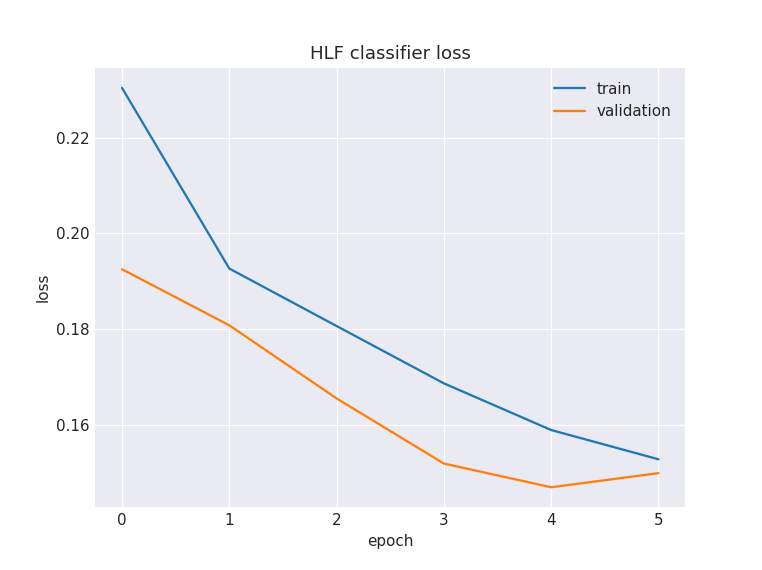

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt 
plt.style.use('seaborn-darkgrid')
# Graph with loss vs. epoch

plt.figure()
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.title("HLF classifier loss")
plt.show()

<IPython.core.display.Javascript object>


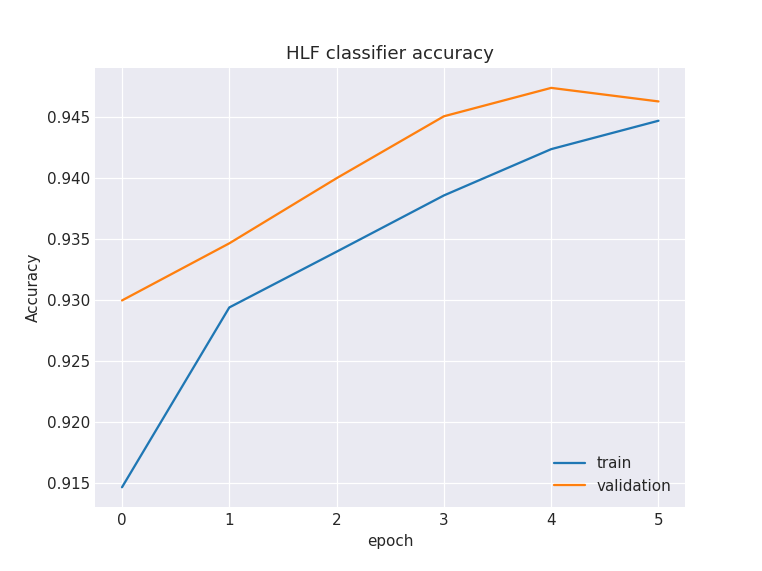

In [22]:
# Graph with accuracy vs. epoch
%matplotlib notebook
plt.figure()
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(loc='lower right')
plt.title("HLF classifier accuracy")
plt.show()

## Confusion Matrix

In [25]:
# model = tf.keras.models.load_model("./mymodel.tf")

In [ ]:
# Optionally run this
# %time model.evaluate(test)

In [25]:
%time y_pred = model.predict(test)
num_entries=y_pred[:,0].size

6689/6689 [==============================] - 967s 145ms/step
CPU times: user 4min 6s, sys: 17min 57s, total: 22min 3s
Wall time: 16min 12s


In [26]:
%time y_test_all = [labels.numpy() for features,labels in parsed_test_dataset.__iter__()]

2023-06-04 21:27:40.674704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]
2023-06-04 21:27:40.675411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [200]
	 [[{{node Placeholder/_0}}]]


CPU times: user 6min 51s, sys: 4min 34s, total: 11min 26s
Wall time: 6min 46s


In [27]:
y_true = np.stack(y_test_all[:num_entries])

In [28]:
from sklearn.metrics import accuracy_score

print('Accuracy of the classifier: {:.4f}'.format(
    accuracy_score(np.argmax(y_true, axis=1),np.argmax(y_pred, axis=1))))

Accuracy of the classifier: 0.9462


/tmp/ipykernel_696/950292951.py:9: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cm = cm / cm.astype(np.float).sum(axis=1)


<IPython.core.display.Javascript object>


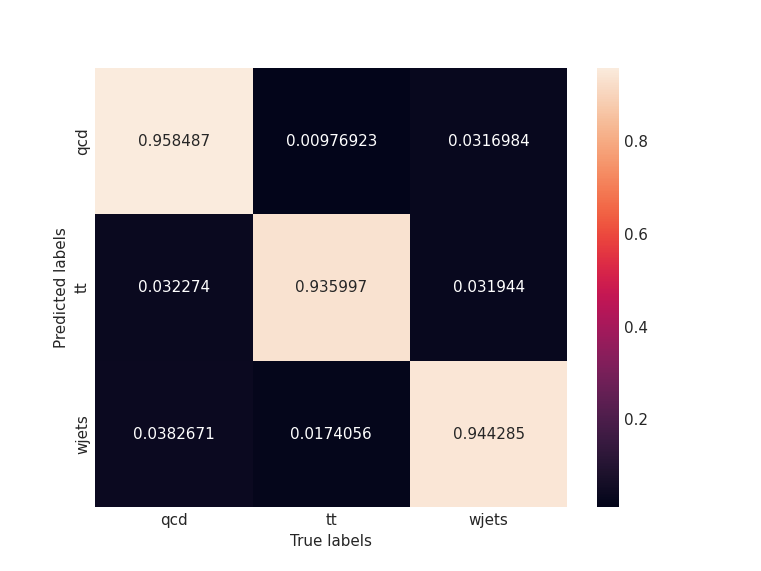

In [29]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
labels_name = ['qcd', 'tt', 'wjets']
labels = [0,1,2]

cm = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1), labels=labels)

## Normalize CM
cm = cm / cm.astype(np.float).sum(axis=1)

fig, ax = plt.subplots()
ax = sns.heatmap(cm, annot=True, fmt='g')
ax.xaxis.set_ticklabels(labels_name)
ax.yaxis.set_ticklabels(labels_name)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

## ROC and AUC

In [30]:
from sklearn.metrics import roc_curve, auc

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(3):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [31]:
# Dictionary containign ROC-AUC for the three classes 
roc_auc

{0: 0.9936400941715727, 1: 0.994817438367295, 2: 0.9922890256542002}

<IPython.core.display.Javascript object>


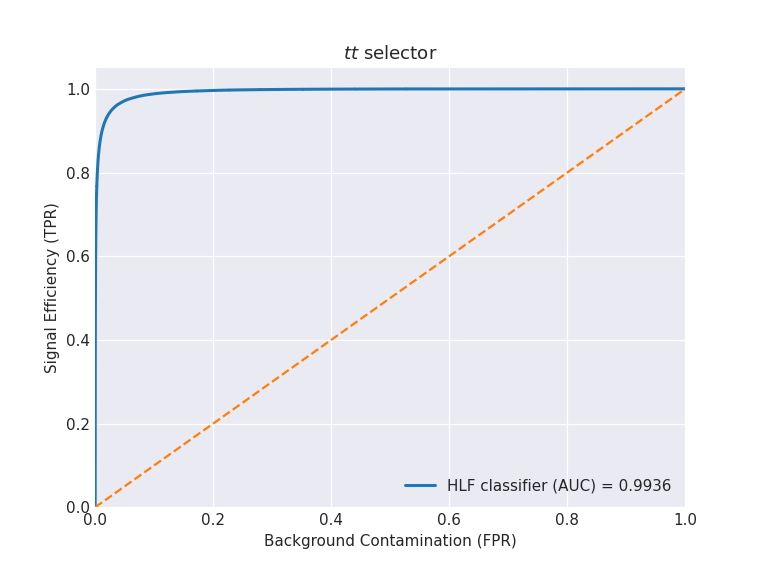

In [32]:
%matplotlib notebook

# Plot roc curve 
import matplotlib.pyplot as plt
plt.style.use('seaborn-darkgrid')


plt.figure()
plt.plot(fpr[0], tpr[0], lw=2, 
         label='HLF classifier (AUC) = %0.4f' % roc_auc[0])
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Background Contamination (FPR)')
plt.ylabel('Signal Efficiency (TPR)')
plt.title('$tt$ selector')
plt.legend(loc="lower right")
plt.show()